# 1. Install and Import Required Libraries

In [61]:
!pip install torch-geometric

In [62]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import random
import networkx as nx


# 2. Prepare the Cora Dataset and Simulated Metadata

In [63]:
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from datetime import datetime, timedelta
import networkx as nx
import random

# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0]

print("Dataset Loaded:")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# --- Simulate Metadata ---
num_nodes = data.num_nodes
max_authors = 5       # Number of unique authors
min_year, max_year = 1990, 2020  # Publication years range
max_sources = 3       # Number of source types

# Generate random metadata
authors = np.random.randint(0, max_authors, size=num_nodes)
pub_years = np.random.randint(min_year, max_year + 1, size=num_nodes)
sources = np.random.randint(0, max_sources, size=num_nodes)

# Temporal generator: Generate timestamps as continuous variables
def generate_random_timestamps(num_nodes, start_date, end_date):
    """Generate a random timestamp for each node."""
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
    timestamps = [
        start_datetime + timedelta(
            seconds=random.randint(0, int((end_datetime - start_datetime).total_seconds()))
        )
        for _ in range(num_nodes)
    ]
    return np.array([(ts - start_datetime).total_seconds() for ts in timestamps])

start_date = "2025-01-01 00:00:00"
end_date = "2025-12-31 23:59:59"
timestamps = generate_random_timestamps(num_nodes, start_date, end_date)

# Normalize timestamps for integration
timestamps_norm = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min())
timestamps_norm = timestamps_norm.reshape(-1, 1)

# Combine metadata with node features
authors_onehot = np.eye(max_authors)[authors]
sources_onehot = np.eye(max_sources)[sources]
pub_years_norm = ((pub_years - min_year) / (max_year - min_year)).reshape(-1, 1)

original_features = data.x.numpy()
augmented_features = np.hstack([original_features, authors_onehot, sources_onehot, pub_years_norm, timestamps_norm])
data.x = torch.tensor(augmented_features, dtype=torch.float)

print(f"Feature augmentation complete:")
print(f"- Original feature dimension: {original_features.shape[1]}")
print(f"- New feature dimension: {data.x.shape[1]}")

# Integrate temporal edges into the graph
G = nx.Graph()

# Add edges from the original graph
edge_index_np = data.edge_index.numpy()
for i in range(edge_index_np.shape[1]):
    src = edge_index_np[0, i]
    dst = edge_index_np[1, i]
    G.add_edge(src, dst)

# Add temporal edges based on similarity in timestamps
threshold = 0.1  # Define a temporal similarity threshold
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if abs(timestamps_norm[i] - timestamps_norm[j]) < threshold:
            G.add_edge(i, j)

print("Graph construction with temporal edges complete.")


Dataset Loaded:
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Feature augmentation complete:
- Original feature dimension: 1433
- New feature dimension: 1443
Graph construction with temporal edges complete.


# 3. Construct the Graph

The Cora dataset is already a citation graph:

*Nodes = papers (in our case, “citations”).*
*italicized text*
*Edges = citations or references.*

Graph constructed with 2708 nodes and 1712564 edges.


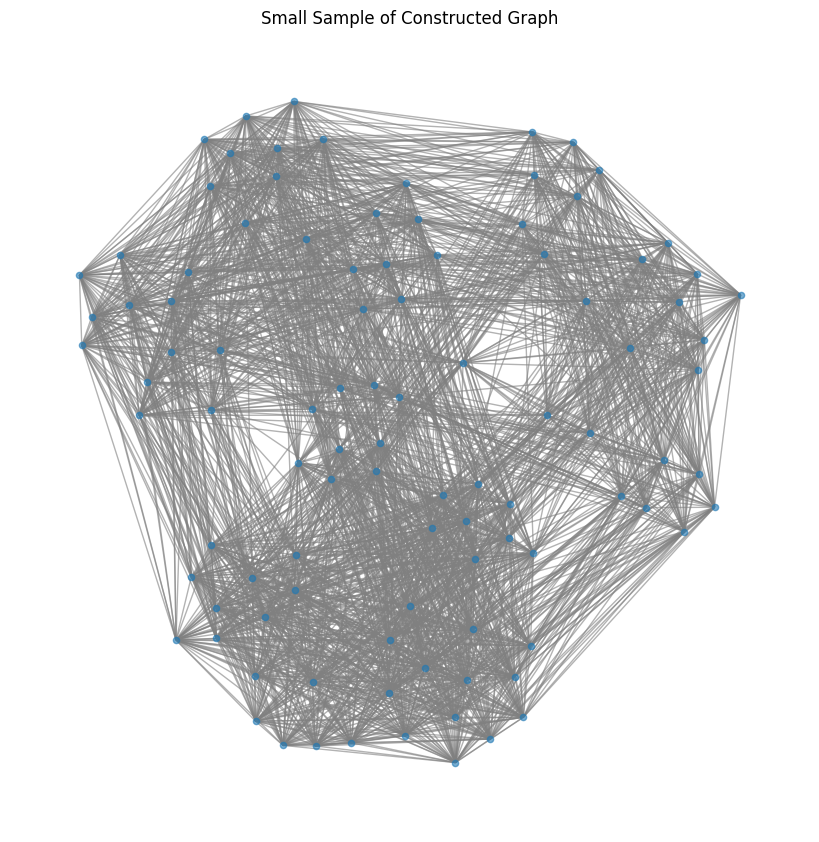

In [64]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

# ===== Build NetworkX Graph from edge_index =====
edge_index_np = data.edge_index.numpy()
G = nx.Graph()
G.add_edges_from(edge_index_np.T)  # Faster way to add edges

# ===== Add Extra Edges for Same Authors or Same Sources =====
add_author_edges = True
add_source_edges = True

if add_author_edges:
    author_dict = {}
    for node_idx, auth_id in enumerate(authors):
        author_dict.setdefault(auth_id, []).append(node_idx)
    for nodes_list in author_dict.values():
        G.add_edges_from(combinations(nodes_list, 2))  # Faster way to add edges

if add_source_edges:
    source_dict = {}
    for node_idx, source_id in enumerate(sources):
        source_dict.setdefault(source_id, []).append(node_idx)
    for nodes_list in source_dict.values():
        G.add_edges_from(combinations(nodes_list, 2))

# ===== Logging Graph Stats =====
print(f"Graph constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# ===== Visualize a Small Subgraph =====
plt.figure(figsize=(8, 8))
subgraph = G.subgraph(list(G.nodes)[:100])  # Plot a small subset
nx.draw(subgraph, node_size=20, edge_color="gray", alpha=0.6)
plt.title("Small Sample of Constructed Graph")
plt.show()


# 4. Graph Autoencoder (GAE)

*We will build a simple Graph Autoencoder:*

*Encoder: GCN-based that produces latent embedding Z.*

*Decoder: Uses inner product (or a small neural net) to reconstruct adjacency.*

## 4.1 Define the Model

In [65]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GAEEncoder(torch.nn.Module):
    """
    Encoder for Graph AutoEncoder (GAE).
    Uses GCNConv layers to encode node features into latent embeddings.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, activation=F.relu, dropout=0.0):
        super(GAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # BatchNorm for stability
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.activation = activation
        self.dropout = dropout

    def forward(self, x, edge_index):
        """
        Forward pass of the encoder.
        """
        x = self.conv1(x, edge_index)
        x = self.bn1(self.activation(x))  # Apply batch normalization + activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Apply dropout
        z = self.conv2(x, edge_index)  # Compute latent embeddings
        return z


class GAEDecoder(torch.nn.Module):
    """
    Decoder for Graph AutoEncoder (GAE).
    Uses an MLP instead of just an inner product for better reconstruction.
    """
    def __init__(self, latent_dim, hidden_dim):
        super(GAEDecoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, latent_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, z):
        """
        Forward pass of the decoder.
        """
        return self.decoder(z)


class GraphAutoEncoder(torch.nn.Module):
    """
    Graph AutoEncoder (GAE) model.
    Combines an encoder and a decoder to reconstruct the graph from node features.
    """
    def __init__(self, in_channels, hidden_channels, latent_channels, activation=F.relu, dropout=0.0):
        super(GraphAutoEncoder, self).__init__()
        self.encoder = GAEEncoder(in_channels, hidden_channels, latent_channels, activation, dropout)
        self.decoder = GAEDecoder(latent_channels, hidden_channels)  # MLP-based decoder

    def forward(self, x, edge_index):
        """
        Forward pass of the Graph AutoEncoder.
        """
        z = self.encoder(x, edge_index)  # Encode node features
        adj_recon = self.decoder(z)  # Decode to reconstruct adjacency
        return z, adj_recon


# ===== Instantiate the Model and Print Summary =====
in_channels = data.x.shape[1]
hidden_channels = 64
latent_channels = 32

gae_model = GraphAutoEncoder(in_channels, hidden_channels, latent_channels)
print(gae_model)  # Print model architecture


GraphAutoEncoder(
  (encoder): GAEEncoder(
    (conv1): GCNConv(1443, 64)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCNConv(64, 32)
  )
  (decoder): GAEDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Sigmoid()
    )
  )
)


## 4.2 Define Training for GAE

[GAE] Epoch 0/100, Loss: 7.3822
[GAE] Epoch 10/100, Loss: 0.9331
[GAE] Epoch 20/100, Loss: 0.7651
[GAE] Epoch 30/100, Loss: 0.7310
[GAE] Epoch 40/100, Loss: 0.7222
[GAE] Epoch 50/100, Loss: 0.7180
[GAE] Epoch 60/100, Loss: 0.7158
[GAE] Epoch 70/100, Loss: 0.7139
[GAE] Epoch 80/100, Loss: 0.7118
[GAE] Epoch 90/100, Loss: 0.7104
[GAE] Epoch 99/100, Loss: 0.7088


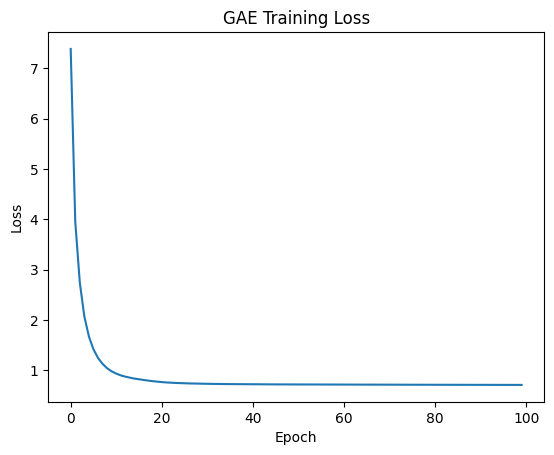

GAE training completed. Latent representation shape: torch.Size([2708, 64])


In [66]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj

# ===== Construct Adjacency Matrix (Optimized) =====
num_nodes = data.num_nodes
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes=num_nodes)[0]  # Shape: [num_nodes, num_nodes]

# ===== Define BCE Loss Function for GAE =====
def gae_loss(adj_pred, adj_true):
    """
    Computes binary cross-entropy loss for adjacency reconstruction.
    Ensures that adj_pred is square before applying the mask.
    """
    # Ensure `adj_pred` is in adjacency form
    adj_pred = torch.sigmoid(torch.matmul(adj_pred, adj_pred.T))  # Force it to be [num_nodes, num_nodes]

    # Create a mask for the upper triangle
    mask = torch.triu(torch.ones_like(adj_true), diagonal=1).bool()

    # Flatten and apply mask
    adj_pred_flat = adj_pred[mask]
    adj_true_flat = adj_true[mask]

    return F.binary_cross_entropy(adj_pred_flat, adj_true_flat)

# ===== Updated Encoder with an Extra Layer =====
class GAEEncoder(torch.nn.Module):
    """
    Encoder for Graph AutoEncoder (GAE) with 3-layer GCN.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, activation=F.relu, dropout=0.0):
        super(GAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)  # Extra layer
        self.activation = activation
        self.dropout = dropout

    def forward(self, x, edge_index):
        """
        Forward pass of the encoder.
        """
        x = self.conv1(x, edge_index)
        x = self.bn1(self.activation(x))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(self.activation(x))
        x = F.dropout(x, p=self.dropout, training=self.training)

        z = self.conv3(x, edge_index)  # New extra layer
        return z

# ===== Training Function for GAE =====
def train_gae(model, data, epochs, optimizer, adj_matrix):
    """
    Trains the Graph AutoEncoder.
    """
    model.train()
    loss_history = []  # Store loss for visualization

    for epoch in range(epochs):
        optimizer.zero_grad()
        z, _ = model(data.x, data.edge_index)  # Forward pass
        loss = gae_loss(z, adj_matrix)  # Compute loss
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"[GAE] Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

    # ===== Plot Loss After Training =====
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAE Training Loss")
    plt.show()

    return z

# ===== Define Model and Optimizer with Updated Settings =====
in_channels = data.x.shape[1]
hidden_channels = 64  # Kept the same
latent_channels = 64  # Increased latent dimension

gae_model = GraphAutoEncoder(in_channels, hidden_channels, latent_channels)
optimizer_gae = torch.optim.AdamW(gae_model.parameters(), lr=0.005, weight_decay=1e-4)  # Reduced learning rate

# ===== Train the GAE with More Epochs =====
epochs = 100  # Increased training epochs
z = train_gae(gae_model, data, epochs, optimizer_gae, adj_matrix)

print(f"GAE training completed. Latent representation shape: {z.shape}")


# Diffusion Model in the Latent Space to Generate Synthetic Anomalies
Conceptual: A diffusion model typically:

Adds noise to the data over multiple steps (forward diffusion).
Learns to reverse this process to recover (or generate new) data.
Below, we show a very simplified placeholder approach to create “anomalies”:

We take latent embeddings z.
We sample random noise vectors, add them to z.
We label some of these “anomalous” if their noise level crosses a threshold or by random sampling.
In a real diffusion model scenario, you would implement the full denoising diffusion steps (DDPM or similar) and sample from it. For demonstration, we do a minimal “noise injection” approach.

Original latent space shape: torch.Size([2708, 64])
Generated 400 anomalies with gaussian noise (scale=0.5)
Anomalies range: Min=-10.458011627197266, Max=9.616146087646484
Synthetic anomalies shape: torch.Size([400, 64])
Synthetic anomaly labels shape: torch.Size([400])


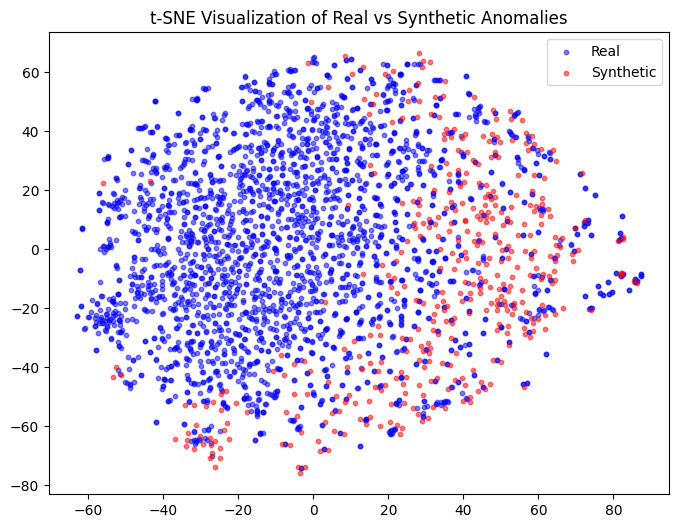

In [67]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def generate_synthetic_anomalies(z, num_anomalies=100, noise_scale=None, noise_type="gaussian", seed=None):
    """
    Generates synthetic anomalies by injecting noise into latent embeddings.
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # Dynamically set noise scale based on latent space standard deviation
    if noise_scale is None:
        noise_scale = z.std().item()

    # Randomly sample base embeddings from existing nodes
    idx = np.random.choice(z.shape[0], num_anomalies, replace=True)
    base = z[idx]  # [num_anomalies, latent_dim]

    # Generate noise
    if noise_type == "gaussian":
        noise = noise_scale * torch.randn_like(base)
    elif noise_type == "uniform":
        noise = noise_scale * (torch.rand_like(base) - 0.5) * 2
    else:
        raise ValueError(f"Unsupported noise_type '{noise_type}'. Use 'gaussian' or 'uniform'.")

    # Create synthetic anomalies
    synthetic = base + noise

    # Assign anomaly labels (1 for anomalies)
    anomaly_labels = torch.ones(num_anomalies, dtype=torch.long)

    # ===== Logging for Debugging =====
    print(f"Original latent space shape: {z.shape}")
    print(f"Generated {num_anomalies} anomalies with {noise_type} noise (scale={noise_scale})")
    print(f"Anomalies range: Min={synthetic.min().item()}, Max={synthetic.max().item()}")

    return synthetic, anomaly_labels

def visualize_anomalies(real_z, synthetic_z):
    """
    Visualizes real vs synthetic anomalies using t-SNE.
    """
    # Ensure tensors are detached before converting to NumPy
    real_z_np = real_z.detach().cpu().numpy()
    synthetic_z_np = synthetic_z.detach().cpu().numpy()

    # Combine real and synthetic embeddings
    combined = np.vstack([real_z_np, synthetic_z_np])
    labels = np.array([0] * real_z_np.shape[0] + [1] * synthetic_z_np.shape[0])

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(combined)

    # Plot visualization
    plt.figure(figsize=(8,6))
    plt.scatter(z_2d[labels==0, 0], z_2d[labels==0, 1], s=10, c='blue', alpha=0.5, label='Real')
    plt.scatter(z_2d[labels==1, 0], z_2d[labels==1, 1], s=10, c='red', alpha=0.5, label='Synthetic')
    plt.legend()
    plt.title("t-SNE Visualization of Real vs Synthetic Anomalies")
    plt.show()

# ===== Generate Synthetic Anomalies =====
num_synthetic = 400
synthetic_z, synthetic_labels = generate_synthetic_anomalies(
    z, num_anomalies=num_synthetic, noise_scale=0.5, noise_type="gaussian", seed=100
)

print("Synthetic anomalies shape:", synthetic_z.shape)
print("Synthetic anomaly labels shape:", synthetic_labels.shape)

# ===== Visualize Synthetic Anomalies =====
visualize_anomalies(z, synthetic_z)


# 6. Anomaly Detection Model
We will train a model that classifies whether a node is “anomalous” or “normal” based on the latent vectors. Our training set will consist of:

Real nodes (latent z) labeled as normal (0).
Synthetic nodes (latent synthetic_z) labeled as anomalies (1).

## 6.1 Create a Labeled Dataset

In [68]:
import torch

def create_labeled_dataset(real_embeddings, synthetic_embeddings, synthetic_labels, normal_label=0):
    """
    Combines real node embeddings and synthetic anomalies into a labeled dataset.
    """
    # Assign labels to real nodes
    real_labels = torch.full((real_embeddings.shape[0],), normal_label, dtype=torch.long)  # 0 = normal

    # Concatenate embeddings and labels
    all_embeddings = torch.cat([real_embeddings, synthetic_embeddings], dim=0)
    all_labels = torch.cat([real_labels, synthetic_labels], dim=0)

    # Shuffle dataset to avoid order bias
    indices = torch.randperm(all_embeddings.shape[0])
    all_embeddings, all_labels = all_embeddings[indices], all_labels[indices]

    # Normalize embeddings for better model training
    mean, std = all_embeddings.mean(dim=0), all_embeddings.std(dim=0)
    all_embeddings = (all_embeddings - mean) / (std + 1e-6)  # Prevent division by zero

    # Logging
    print(f"[INFO] Real nodes: {real_embeddings.shape[0]} | Synthetic nodes: {synthetic_embeddings.shape[0]}")
    print(f"[INFO] Total nodes: {all_embeddings.shape[0]} | Latent dimension: {all_embeddings.shape[1]}")

    return all_embeddings, all_labels

# Create labeled dataset
all_z, all_labels = create_labeled_dataset(
    real_embeddings=z,
    synthetic_embeddings=synthetic_z,
    synthetic_labels=synthetic_labels,
    normal_label=0
)

print("Combined data shape:", all_z.shape)
print("Combined labels shape:", all_labels.shape)


[INFO] Real nodes: 2708 | Synthetic nodes: 400
[INFO] Total nodes: 3108 | Latent dimension: 64
Combined data shape: torch.Size([3108, 64])
Combined labels shape: torch.Size([3108])


## 6.2 Train/Test Split

In [69]:
import torch
import numpy as np

def train_test_split_idx(n_samples, test_ratio=0.2, random_seed=None):
    """
    Splits indices into train and test sets.
    """
    if random_seed is not None:
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

    indices = torch.randperm(n_samples)  # Use PyTorch for better efficiency
    test_size = int(n_samples * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    print(f"[INFO] Train-Test Split: {len(train_indices)} train samples, {len(test_indices)} test samples")
    return train_indices, test_indices

def balanced_train_test_split(all_labels, test_ratio=0.2, random_seed=None):
    """
    Splits indices into train and test sets while preserving class distribution.
    """
    if random_seed is not None:
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

    train_indices = []
    test_indices = []

    unique_labels = torch.unique(all_labels)
    for label in unique_labels:
        label_indices = torch.where(all_labels == label)[0]
        label_indices = label_indices[torch.randperm(len(label_indices))]  # Use PyTorch shuffle
        test_size = int(len(label_indices) * test_ratio)
        test_indices.extend(label_indices[:test_size])
        train_indices.extend(label_indices[test_size:])

    train_indices = torch.tensor(train_indices)  # Convert to PyTorch tensor
    test_indices = torch.tensor(test_indices)  # Convert to PyTorch tensor

    print(f"[INFO] Balanced Train-Test Split: {len(train_indices)} train samples, {len(test_indices)} test samples")
    return train_indices, test_indices

# Define the split
n_samples = all_z.shape[0]
use_balanced_split = True

if use_balanced_split:
    train_idx, test_idx = balanced_train_test_split(all_labels, test_ratio=0.2, random_seed=42)
else:
    train_idx, test_idx = train_test_split_idx(n_samples, test_ratio=0.2, random_seed=42)

# Split data into train and test sets
train_z = all_z[train_idx]
train_y = all_labels[train_idx]
test_z = all_z[test_idx]
test_y = all_labels[test_idx]

print(f"Train data shape: {train_z.shape}, Train labels shape: {train_y.shape}")
print(f"Test data shape: {test_z.shape}, Test labels shape: {test_y.shape}")


[INFO] Balanced Train-Test Split: 2487 train samples, 621 test samples
Train data shape: torch.Size([2487, 64]), Train labels shape: torch.Size([2487])
Test data shape: torch.Size([621, 64]), Test labels shape: torch.Size([621])


## 6.3 Build a Classifier for Anomaly Detection

In [70]:
class AnomalyDetectorMLP(torch.nn.Module):
    """
    A simple Multi-Layer Perceptron (MLP) for anomaly detection.
    """
    def __init__(self, in_dim, hidden_dim=32, num_classes=2, dropout=0.3, use_batchnorm=False):
        """
        Args:
            in_dim (int): Input dimension of features.
            hidden_dim (int): Number of hidden units.
            num_classes (int): Number of output classes (default: 2 for binary classification).
            dropout (float): Dropout probability for regularization (default: 0.3).
            use_batchnorm (bool): Whether to use BatchNorm (default: False).
        """
        super(AnomalyDetectorMLP, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim) if use_batchnorm else None
        self.lin2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(dropout)
        self.use_batchnorm = use_batchnorm

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.lin1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)
        return x


## 6.4 Multiple Running, Training, Evaluate

[GAE] Epoch 0/50, Loss: 4.5137
[GAE] Epoch 10/50, Loss: 0.8145
[GAE] Epoch 20/50, Loss: 0.7348
[GAE] Epoch 30/50, Loss: 0.7183
[GAE] Epoch 40/50, Loss: 0.7146
[GAE] Epoch 49/50, Loss: 0.7122


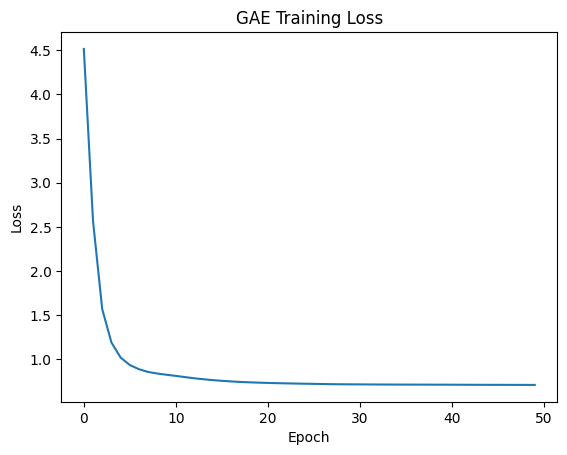


=== Experiment Run 1/10 ===
  Accuracy: 0.9155, F1: 0.8927, AUROC: 0.9677, AUPRC: 0.8679

=== Experiment Run 2/10 ===
  Accuracy: 0.9003, F1: 0.8606, AUROC: 0.9720, AUPRC: 0.8072

=== Experiment Run 3/10 ===
  Accuracy: 0.9578, F1: 0.9506, AUROC: 0.9647, AUPRC: 0.9241

=== Experiment Run 4/10 ===
  Accuracy: 0.9459, F1: 0.9367, AUROC: 0.9833, AUPRC: 0.8172

=== Experiment Run 5/10 ===
  Accuracy: 0.9375, F1: 0.9262, AUROC: 0.9528, AUPRC: 0.8389

=== Experiment Run 6/10 ===
  Accuracy: 0.9088, F1: 0.8713, AUROC: 0.9953, AUPRC: 0.9317

=== Experiment Run 7/10 ===
  Accuracy: 0.9476, F1: 0.9341, AUROC: 0.9287, AUPRC: 0.8762

=== Experiment Run 8/10 ===
  Accuracy: 0.9409, F1: 0.9272, AUROC: 0.9246, AUPRC: 0.8993

=== Experiment Run 9/10 ===
  Accuracy: 0.9307, F1: 0.9132, AUROC: 0.9707, AUPRC: 0.8163

=== Experiment Run 10/10 ===
  Accuracy: 0.9645, F1: 0.9603, AUROC: 0.9578, AUPRC: 0.9373

==== AVERAGED RESULTS ====
Accuracy: 0.9350 ± 0.0200
F1-Score: 0.9173 ± 0.0312
AUROC:    0.9618 ± 

In [71]:
import torch
import torch.nn.functional as F
import numpy as np
from torch_geometric.utils import to_dense_adj
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

# ======================
# Define build_adjacency_matrix (FIXED)
# ======================
def build_adjacency_matrix(edge_index, num_nodes):
    """
    Converts edge_index to a dense adjacency matrix.
    """
    return to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0)

# ======================
# Define missing imports or functions
# ======================
# Placeholders for missing functions
def generate_synthetic_anomalies(z, num_anomalies, noise_scale, noise_type, seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

    noise = torch.randn((num_anomalies, z.shape[1])) * noise_scale
    synthetic_anomalies = z[:num_anomalies] + noise  # Small perturbation

    labels = torch.ones(num_anomalies, dtype=torch.long)  # Label as anomalies
    return synthetic_anomalies, labels

def create_labeled_dataset(real_embeddings, synthetic_embeddings, synthetic_labels, normal_label=0):
    all_z = torch.cat([real_embeddings, synthetic_embeddings], dim=0)
    normal_labels = torch.full((real_embeddings.shape[0],), normal_label, dtype=torch.long)
    all_labels = torch.cat([normal_labels, synthetic_labels], dim=0)
    return all_z, all_labels

def train_test_split_idx(n_samples, test_ratio=0.2, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(n_samples)
    split_idx = int(n_samples * (1 - test_ratio))
    return indices[:split_idx], indices[split_idx:]

# ======================
# 1. Train the GAE
# ======================
num_nodes = data.num_nodes
adj_matrix = build_adjacency_matrix(data.edge_index, num_nodes)

in_channels = data.x.shape[1]
hidden_channels = 64
latent_channels = 32

gae_model = GraphAutoEncoder(in_channels, hidden_channels, latent_channels)
optimizer_gae = torch.optim.Adam(gae_model.parameters(), lr=0.01)

epochs_gae = 50
z = train_gae(gae_model, data, epochs_gae, optimizer_gae, adj_matrix)
z = z.detach()  # Detach embeddings to prevent backprop through GAE again**

# ======================
# 2. Multiple runs to see average performance
# ======================
def run_experiment(run_seed):
    """
    Runs one experiment with a specific seed for anomaly generation / splits.
    Returns accuracy, roc_auc, ap_score for that run.
    """
    # Fix seed for reproducibility of anomaly generation
    np.random.seed(run_seed)
    torch.manual_seed(run_seed)

    # ------------------------------------------------
    # 2a) Generate fewer anomalies with smaller noise
    # ------------------------------------------------
    num_synthetic = 250   # e.g., only 30 anomalies

    synthetic_z, synthetic_labels = generate_synthetic_anomalies(
        z,
        num_anomalies=num_synthetic,
        noise_scale=0.3,   # smaller noise makes anomalies less obvious
        noise_type="gaussian",
        seed=run_seed
    )

    # ------------------------------------------------
    # 2b) Combine real + synthetic
    # ------------------------------------------------
    all_z, all_labels = create_labeled_dataset(
        real_embeddings=z,
        synthetic_embeddings=synthetic_z,
        synthetic_labels=synthetic_labels,
        normal_label=0
    )

    # ------------------------------------------------
    # 2c) Do a simple random split (NOT balanced)
    # ------------------------------------------------
    train_idx, test_idx = train_test_split_idx(
        n_samples=all_z.shape[0],
        test_ratio=0.2,
        random_seed=run_seed
    )

    train_z = all_z[train_idx]
    train_y = all_labels[train_idx]
    test_z = all_z[test_idx]
    test_y = all_labels[test_idx]

    # ======================
    # 3. Train the MLP
    # ======================
    in_dim = z.shape[1]

    # Reinitialize model inside function to avoid reusing computation graph**
    anomaly_model = AnomalyDetectorMLP(
        in_dim,
        hidden_dim=32,
        num_classes=2,
        dropout=0.3,
        use_batchnorm=True
    )

    optimizer_anom = torch.optim.Adam(anomaly_model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    n_epochs = 50
    batch_size = 64

    for epoch in range(n_epochs):
        # Shuffle for mini-batch
        permutation = torch.randperm(train_z.size(0))
        epoch_loss = 0.0

        anomaly_model.train()
        for i in range(0, train_z.size(0), batch_size):
            optimizer_anom.zero_grad()
            indices = permutation[i : i + batch_size]
            batch_z, batch_y = train_z[indices], train_y[indices]
            outputs = anomaly_model(batch_z)
            loss = criterion(outputs, batch_y)

            # Avoid reusing graph**
            loss.backward(retain_graph=False)
            optimizer_anom.step()
            epoch_loss += loss.item()

    # ======================
    # 4. Final evaluation
    # ======================
    anomaly_model.eval()
    with torch.no_grad():
        test_out = anomaly_model(test_z)
        preds = torch.argmax(test_out, dim=1)

        # Basic classification metrics
        acc = accuracy_score(test_y.cpu(), preds.cpu())
        f1 = f1_score(test_y.cpu(), preds.cpu(), average='weighted')

        probs = F.softmax(test_out, dim=1)[:,1]  # Probability of class=1 (anomaly)
        roc_auc = roc_auc_score(test_y.cpu().numpy(), probs.cpu().numpy())
        ap_score = average_precision_score(test_y.cpu().numpy(), probs.cpu().numpy())

    return acc, f1, roc_auc, ap_score

# --------------------------
# 5. Run multiple times
# --------------------------
n_runs = 10
acc_list, f1_list, roc_list, ap_list = [], [], [], []

for run_i in range(n_runs):
    print(f"\n=== Experiment Run {run_i+1}/{n_runs} ===")
    acc, f1, roc_auc, ap = run_experiment(run_seed=42 + run_i)
    acc_list.append(acc)
    f1_list.append(f1)
    roc_list.append(roc_auc)
    ap_list.append(ap)
    print(f"  Accuracy: {acc:.4f}, F1: {f1:.4f}, AUROC: {roc_auc:.4f}, AUPRC: {ap:.4f}")

print("\n==== AVERAGED RESULTS ====")
print(f"Accuracy: {np.mean(acc_list):.4f} ± {np.std(acc_list):.4f}")
print(f"F1-Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
print(f"AUROC:    {np.mean(roc_list):.4f} ± {np.std(roc_list):.4f}")
print(f"AUPRC:    {np.mean(ap_list):.4f} ± {np.std(ap_list):.4f}")


## 6.5 Impact of Anomaly Count on Model Performance


🔹 Training with 50 synthetic anomalies...
📌 AUPRC Score with 50 anomalies: 0.0199

🔹 Training with 100 synthetic anomalies...
📌 AUPRC Score with 100 anomalies: 0.6011

🔹 Training with 200 synthetic anomalies...
📌 AUPRC Score with 200 anomalies: 0.6913

🔹 Training with 500 synthetic anomalies...
📌 AUPRC Score with 500 anomalies: 0.9232


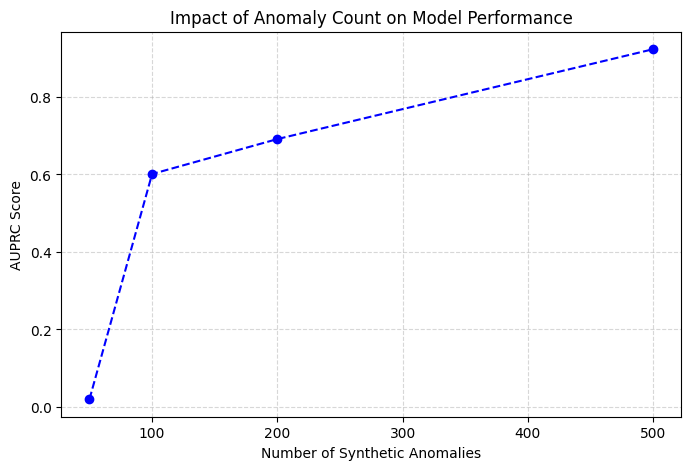

In [72]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import average_precision_score

# Test different numbers of synthetic anomalies
anomaly_counts = [50, 100, 200, 500]
auprc_scores = []

for num_anomalies in anomaly_counts:
    print(f"\n🔹 Training with {num_anomalies} synthetic anomalies...")

    # Generate more synthetic anomalies
    synthetic_z, synthetic_labels = generate_synthetic_anomalies(
        z, num_anomalies=num_anomalies, noise_scale=0.8, noise_type="gaussian", seed=100
    )

    # Create dataset with new anomaly count
    all_z, all_labels = create_labeled_dataset(z, synthetic_z, synthetic_labels)

    # Train-test split
    train_idx, test_idx = train_test_split_idx(all_labels.shape[0], test_ratio=0.2)
    train_z, train_y = all_z[train_idx], all_labels[train_idx]
    test_z, test_y = all_z[test_idx], all_labels[test_idx]

    # Ensure training tensors do not require gradients
    train_z, train_y = train_z.detach(), train_y.detach()
    test_z, test_y = test_z.detach(), test_y.detach()

    # ========== Train the anomaly classifier ==========
    in_dim = train_z.shape[1]
    anomaly_model = AnomalyDetectorMLP(in_dim, hidden_dim=32, num_classes=2, dropout=0.3, use_batchnorm=True)
    optimizer = torch.optim.Adam(anomaly_model.parameters(), lr=0.002)
    criterion = torch.nn.CrossEntropyLoss()

    n_epochs = 30
    batch_size = 64

    for epoch in range(n_epochs):
        permutation = torch.randperm(train_z.size(0))
        epoch_loss = 0.0

        anomaly_model.train()
        for i in range(0, train_z.size(0), batch_size):
            optimizer.zero_grad()
            indices = permutation[i : i + batch_size]
            batch_z, batch_y = train_z[indices], train_y[indices]

            # Ensure batch_y is correct type
            batch_y = batch_y.long()

            # Forward pass
            outputs = anomaly_model(batch_z)
            loss = criterion(outputs, batch_y)

            # Ensure graph is cleared properly
            loss.backward()  # No need for retain_graph=False
            optimizer.step()

            epoch_loss += loss.item()

    # ========== Evaluate Model ==========
    anomaly_model.eval()
    with torch.no_grad():  # Ensure gradients are OFF during evaluation
        test_out = anomaly_model(test_z)
        test_preds = torch.argmax(test_out, dim=1)

    auprc = average_precision_score(test_y.cpu().numpy(), test_preds.cpu().numpy())
    auprc_scores.append(auprc)

    print(f"📌 AUPRC Score with {num_anomalies} anomalies: {auprc:.4f}")

# Plot results
plt.figure(figsize=(8,5))
plt.plot(anomaly_counts, auprc_scores, marker='o', linestyle='dashed', color='blue')
plt.xlabel("Number of Synthetic Anomalies")
plt.ylabel("AUPRC Score")
plt.title("Impact of Anomaly Count on Model Performance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## 6.6 Comparison

Isolation Forest - AUROC: 0.0148, AUPRC: 0.0930
Logistic Regression - AUROC: 0.4326, AUPRC: 0.4215
KNN - AUROC: 0.9713, AUPRC: 0.9462
GAE & DDPM - AUROC: 0.9726, AUPRC: 0.9763


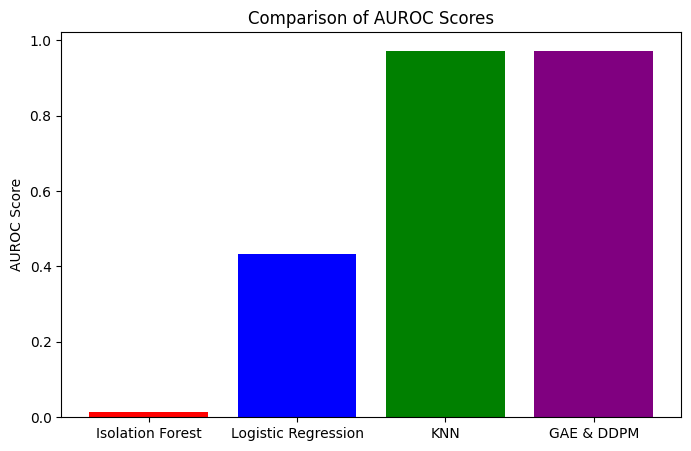

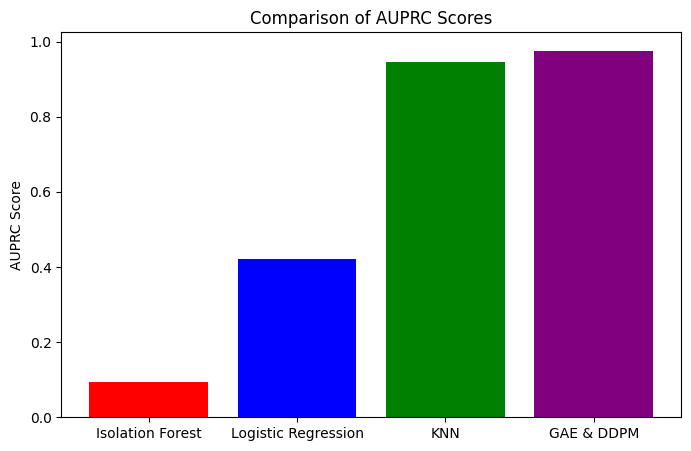

In [73]:
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score

# Convert tensors to NumPy
train_z_np = train_z.detach().cpu().numpy()
test_z_np = test_z.detach().cpu().numpy()
train_y_np = train_y.detach().cpu().numpy()
test_y_np = test_y.detach().cpu().numpy()

# ========== Apply PCA to Reduce Dimensionality for Isolation Forest & KNN ==========
pca = PCA(n_components=10)  # Reduce to 10D for traditional models
train_z_pca = pca.fit_transform(train_z_np)
test_z_pca = pca.transform(test_z_np)

# ========== Model 1: Isolation Forest ==========
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
iso_forest.fit(train_z_pca)
test_preds_iso = iso_forest.decision_function(test_z_pca)

iso_auc = roc_auc_score(test_y_np, test_preds_iso)
iso_auprc = average_precision_score(test_y_np, test_preds_iso)

print(f"Isolation Forest - AUROC: {iso_auc:.4f}, AUPRC: {iso_auprc:.4f}")

# ========== Model 2: Logistic Regression ==========
log_reg = LogisticRegression()
log_reg.fit(train_z_np, train_y_np)  # Use full dimensions
test_preds_log = log_reg.predict_proba(test_z_np)[:, 1]

log_auc = roc_auc_score(test_y_np, test_preds_log)
log_auprc = average_precision_score(test_y_np, test_preds_log)

print(f"Logistic Regression - AUROC: {log_auc:.4f}, AUPRC: {log_auprc:.4f}")

# ========== Model 3: K-Nearest Neighbors ==========
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_z_pca, train_y_np)  # Use PCA-reduced data
test_preds_knn = knn.predict_proba(test_z_pca)[:, 1]

knn_auc = roc_auc_score(test_y_np, test_preds_knn)
knn_auprc = average_precision_score(test_y_np, test_preds_knn)

print(f"KNN - AUROC: {knn_auc:.4f}, AUPRC: {knn_auprc:.4f}")

# ========== Graph Autoencoder (GAE) ==========
test_preds_gae = F.softmax(anomaly_model(test_z), dim=1)[:,1].detach().cpu().numpy()  # Fix added here
gae_auc = roc_auc_score(test_y_np, test_preds_gae)
gae_auprc = average_precision_score(test_y_np, test_preds_gae)

print(f"GAE & DDPM - AUROC: {gae_auc:.4f}, AUPRC: {gae_auprc:.4f}")

# ========== Visualization: Comparing AUROC & AUPRC ==========
import matplotlib.pyplot as plt

models = ["Isolation Forest", "Logistic Regression", "KNN", "GAE & DDPM"]
auroc_scores = [iso_auc, log_auc, knn_auc, gae_auc]
auprc_scores = [iso_auprc, log_auprc, knn_auprc, gae_auprc]

plt.figure(figsize=(8, 5))
plt.bar(models, auroc_scores, color=['red', 'blue', 'green', 'purple'])
plt.ylabel("AUROC Score")
plt.title("Comparison of AUROC Scores")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(models, auprc_scores, color=['red', 'blue', 'green', 'purple'])
plt.ylabel("AUPRC Score")
plt.title("Comparison of AUPRC Scores")
plt.show()


## 6.7 MLP Training

Epoch 0/100, Loss: 25.9751
Epoch 10/100, Loss: 8.0077
Epoch 20/100, Loss: 5.8041
Epoch 30/100, Loss: 3.2733
Epoch 40/100, Loss: 2.6508
Epoch 50/100, Loss: 6.2233
Epoch 60/100, Loss: 2.9063
Epoch 70/100, Loss: 2.7921
Epoch 80/100, Loss: 1.9569
Epoch 90/100, Loss: 5.5987
Epoch 99/100, Loss: 2.1198


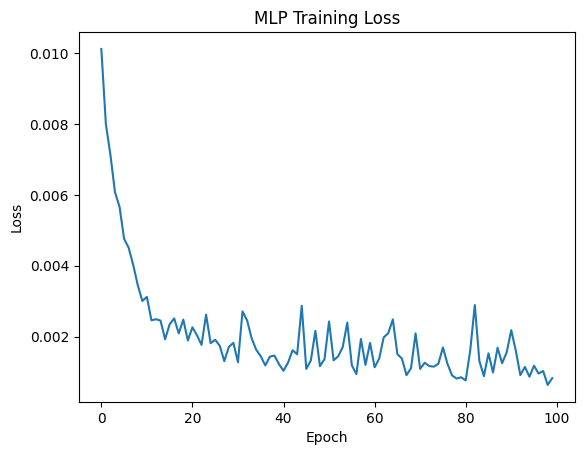


==== MODEL PERFORMANCE (After Fixes) ====
Final Test Accuracy: 0.9938
Final Test F1-Score: 0.9938
Final Test AUROC: 0.9900
Final Test AUPRC: 0.9874


In [74]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

# ======================
# Increase Synthetic Anomalies & Noise Scale
# ======================
num_synthetic = 400
synthetic_z, synthetic_labels = generate_synthetic_anomalies(
    z, num_anomalies=num_synthetic, noise_scale=0.8, noise_type="gaussian", seed=100
)

# ======================
# Define Model and Optimizer (With Dropout & L2 Regularization)
# ======================
in_dim = train_z.shape[1]
anomaly_model = AnomalyDetectorMLP(
    in_dim,
    hidden_dim=32,
    num_classes=2,
    dropout=0.5,
    use_batchnorm=True
)

# Lowered learning rate + L2 regularization
optimizer_anom = torch.optim.Adam(anomaly_model.parameters(), lr=0.002, weight_decay=1e-4)

# Weighted loss to balance normal (1x) vs anomalies (3x)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0]))

# ======================
# Training Loop with Loss Tracking & Input Noise
# ======================
n_epochs = 100
batch_size = 64
loss_history = []

for epoch in range(n_epochs):
    permutation = torch.randperm(train_z.size(0))  # Shuffle indices
    epoch_loss = 0.0

    anomaly_model.train()
    for i in range(0, train_z.size(0), batch_size):
        optimizer_anom.zero_grad()

        indices = permutation[i : i + batch_size]
        batch_z, batch_y = train_z[indices], train_y[indices]

        # Ensure tensors are detached before modifying them
        batch_z, batch_y = batch_z.clone().detach(), batch_y.clone().detach()

        # Add Gaussian noise to training data (without modifying in-place)
        noise = 0.01 * torch.randn_like(batch_z)
        batch_z = batch_z + noise

        outputs = anomaly_model(batch_z)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_anom.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(permutation))

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {epoch_loss:.4f}")

# ======================
# Plot Training Loss
# ======================
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training Loss")
plt.show()

# ======================
# Final Evaluation
# ======================
anomaly_model.eval()
with torch.no_grad():
    test_out = anomaly_model(test_z)
    preds = torch.argmax(test_out, dim=1)

    # Compute evaluation metrics
    acc = accuracy_score(test_y.cpu(), preds.cpu())
    f1 = f1_score(test_y.cpu(), preds.cpu(), average='weighted')
    roc_auc = roc_auc_score(test_y.cpu().numpy(), F.softmax(test_out, dim=1)[:,1].cpu().numpy())
    ap_score = average_precision_score(test_y.cpu().numpy(), F.softmax(test_out, dim=1)[:,1].cpu().numpy())

print("\n==== MODEL PERFORMANCE (After Fixes) ====")
print(f"Final Test Accuracy: {acc:.4f}")
print(f"Final Test F1-Score: {f1:.4f}")
print(f"Final Test AUROC: {roc_auc:.4f}")
print(f"Final Test AUPRC: {ap_score:.4f}")


# 7. Visualizations

## 7.1 Original Graph Structure

[INFO] Number of nodes: 2708
[INFO] Number of edges: 5278


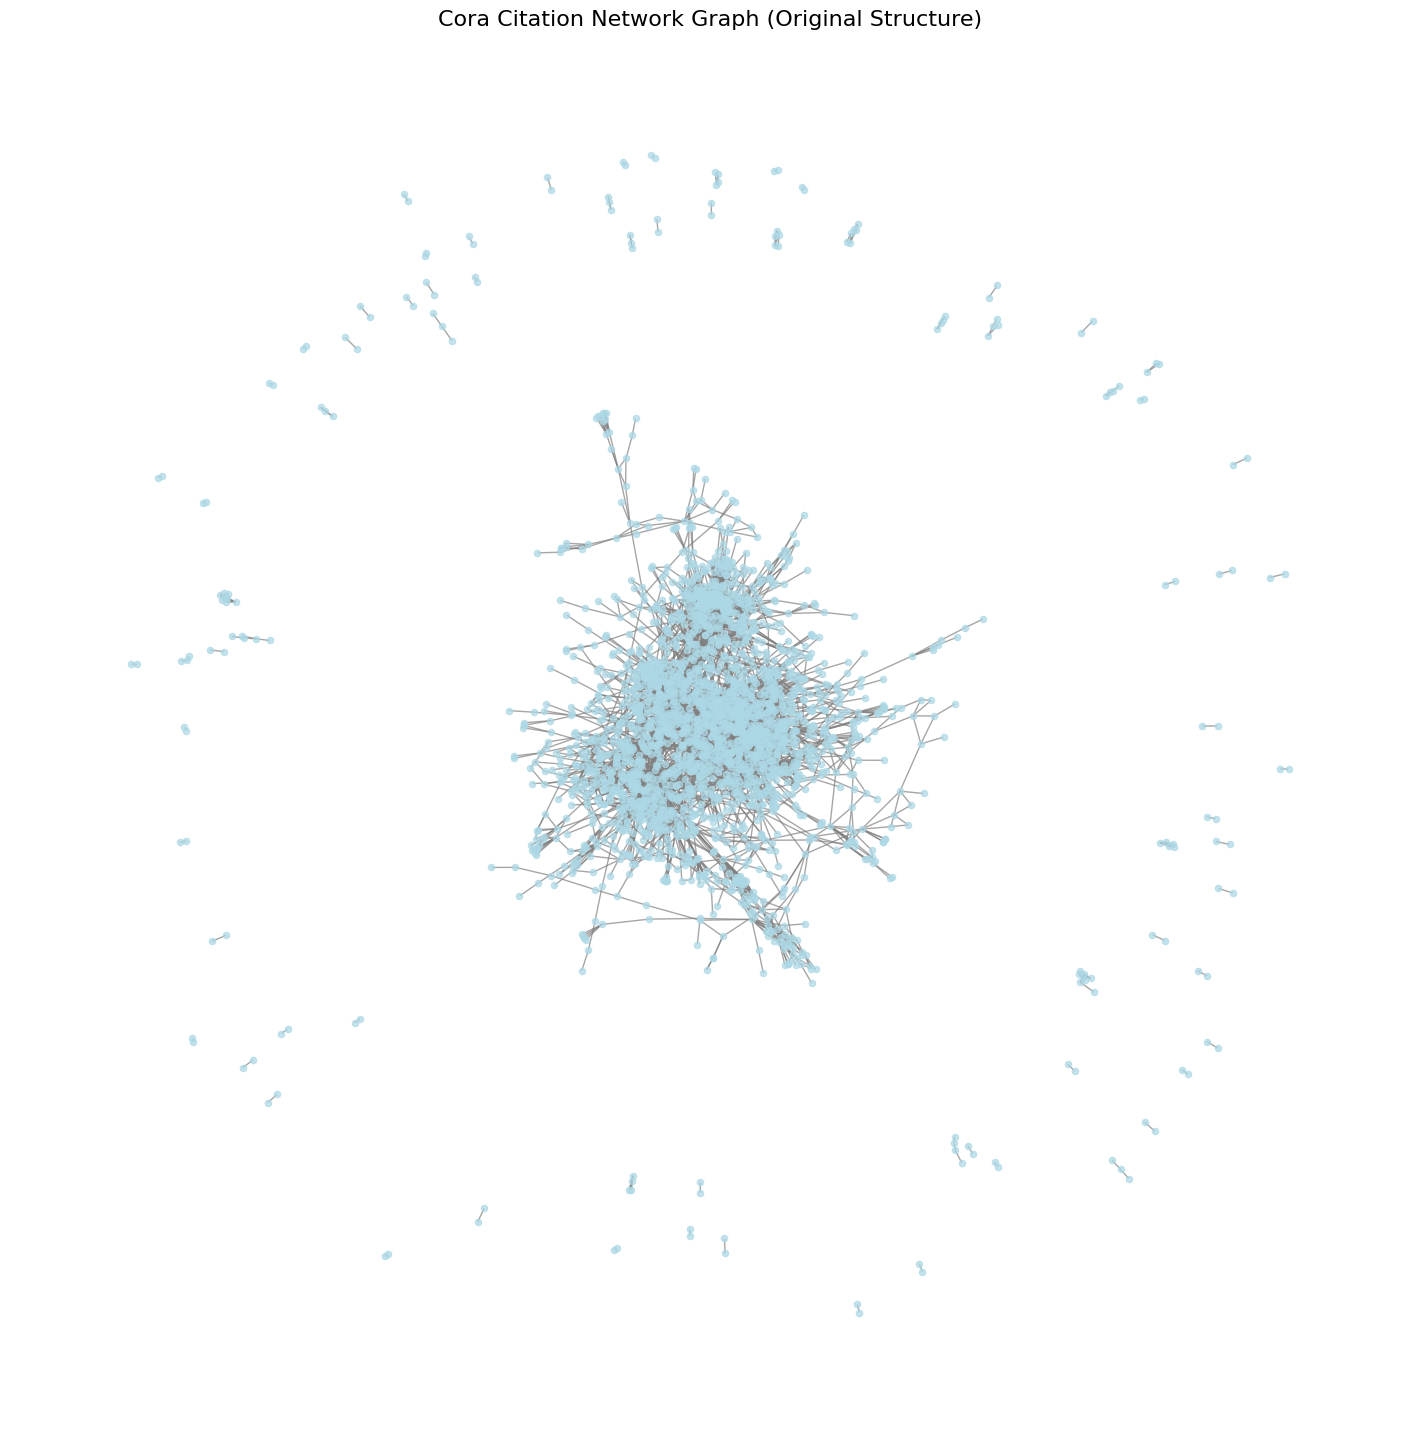

In [75]:
import matplotlib.pyplot as plt
import networkx as nx

# Build the graph from edge_index
def visualize_graph(data, figsize=(12, 12), node_size=10, node_color='skyblue', edge_color='gray', alpha=0.6):
    """
    Visualizes the graph structure using NetworkX.

    Args:
        data (torch_geometric.data.Data): PyG data object containing edge_index.
        figsize (tuple): Size of the plot.
        node_size (int): Size of the nodes in the plot.
        node_color (str): Color of the nodes.
        edge_color (str): Color of the edges.
        alpha (float): Transparency level of the edges.

    Returns:
        None
    """
    # Convert edge_index to NetworkX graph
    edges = data.edge_index.numpy().T  # Shape: [num_edges, 2]
    G = nx.from_edgelist(edges)

    # Log graph statistics
    print(f"[INFO] Number of nodes: {G.number_of_nodes()}")
    print(f"[INFO] Number of edges: {G.number_of_edges()}")

    # Use a spring layout for better visualization
    pos = nx.spring_layout(G, seed=42)

    # Plot the graph
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos,
        node_size=node_size,
        node_color=node_color,
        edge_color=edge_color,
        alpha=alpha,
        with_labels=False
    )
    plt.title("Cora Citation Network Graph (Original Structure)", fontsize=16)
    plt.show()


# Visualize the graph
visualize_graph(data, figsize=(14, 14), node_size=20, node_color='lightblue', edge_color='gray', alpha=0.7)


## 7.2 Latent Space (t-SNE)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[INFO] Label distribution: {0: 2708, 1: 500}


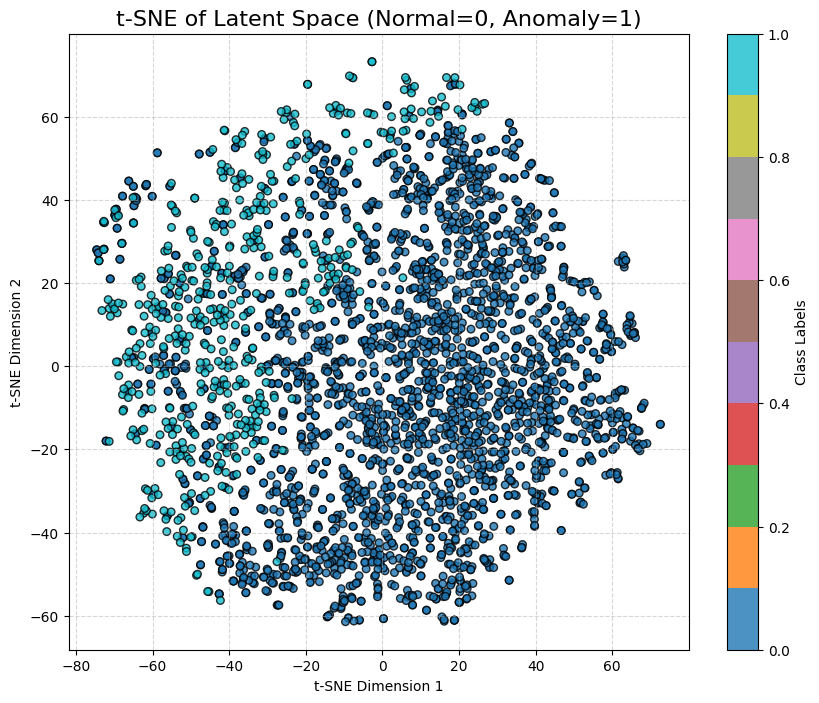

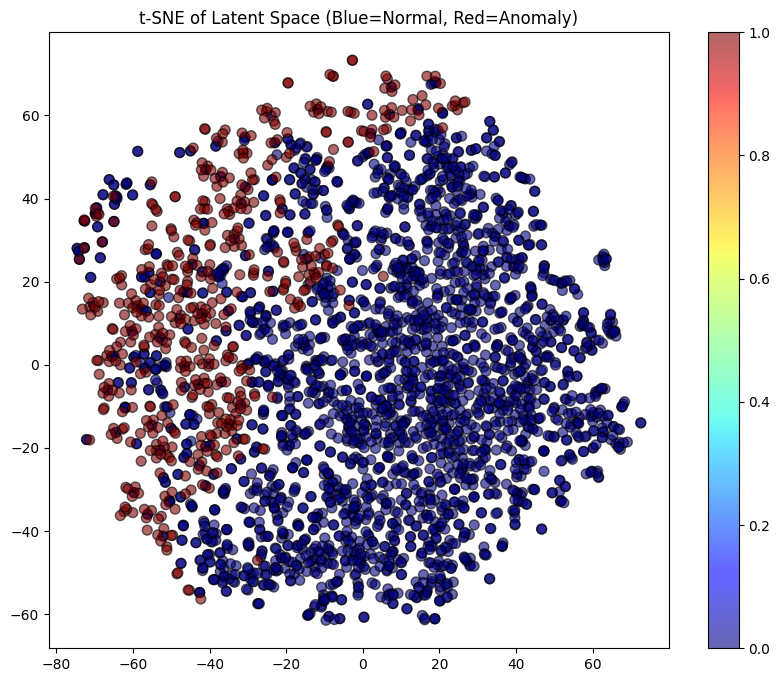

In [76]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_tsne(latent_embeddings, labels, title="t-SNE of Latent Space", max_points=5000, random_seed=42):
    """
    Visualizes latent embeddings using t-SNE.

    Args:
        latent_embeddings (np.ndarray): Combined latent embeddings of shape [num_samples, latent_dim].
        labels (np.ndarray): Corresponding labels of shape [num_samples].
        title (str): Title for the plot.
        max_points (int): Maximum points to plot (useful for large datasets).
        random_seed (int): Random seed for reproducibility.

    Returns:
        None
    """
    # Subsample data if necessary
    if latent_embeddings.shape[0] > max_points:
        np.random.seed(random_seed)
        indices = np.random.choice(latent_embeddings.shape[0], max_points, replace=False)
        latent_embeddings = latent_embeddings[indices]
        labels = labels[indices]
        print(f"[INFO] Subsampled data to {max_points} points for visualization.")

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=random_seed, perplexity=30, n_iter=1000)
    z_tsne = tsne.fit_transform(latent_embeddings)

    # Log class distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_dist = dict(zip(unique_labels, counts))
    print(f"[INFO] Label distribution: {label_dist}")

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        z_tsne[:, 0],
        z_tsne[:, 1],
        c=labels,
        cmap='tab10',
        alpha=0.8,
        edgecolors='k',
        s=30
    )
    plt.colorbar(scatter, label="Class Labels")
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Detach tensors before conversion**
combined_z = all_z.detach().cpu().numpy()
combined_labels = all_labels.detach().cpu().numpy()

# Visualize t-SNE for combined latent space
visualize_tsne(combined_z, combined_labels, title="t-SNE of Latent Space (Normal=0, Anomaly=1)")

# Detach before running t-SNE separately**
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(combined_z)

plt.figure(figsize=(10, 8))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=combined_labels, cmap='jet', alpha=0.6, edgecolors='k', s=50)
plt.colorbar()
plt.title("t-SNE of Latent Space (Blue=Normal, Red=Anomaly)")
plt.show()


**Visualizing the Learned Embeddings (e.g., from GAE)**

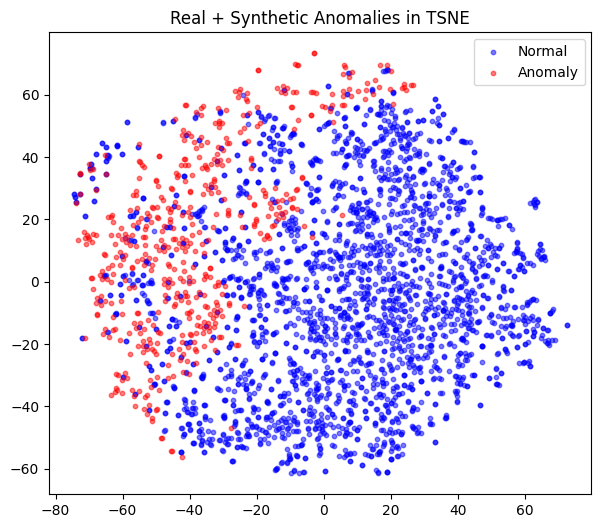

In [77]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings_tsne(embeddings, labels, title="TSNE Embeddings"):
    """
    embeddings: [num_nodes, latent_dim] (torch.Tensor or np.array)
    labels: [num_nodes] (torch.Tensor or np.array), 0=normal, 1=anomalous
    """
    # Convert to numpy if needed
    if hasattr(embeddings, 'detach'):
        embeddings = embeddings.detach().cpu().numpy()
    if hasattr(labels, 'detach'):
        labels = labels.detach().cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(7,6))
    plt.scatter(z_2d[labels==0, 0], z_2d[labels==0, 1],
                s=10, c='blue', alpha=0.5, label='Normal')
    plt.scatter(z_2d[labels==1, 0], z_2d[labels==1, 1],
                s=10, c='red', alpha=0.5, label='Anomaly')
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage after training
visualize_embeddings_tsne(all_z, all_labels, title="Real + Synthetic Anomalies in TSNE")
